In [23]:
import os
import time
import cv2
import joblib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from joblib.externals.loky import get_reusable_executor

dataset_path = 'VOCdevkit/VOC2012/JPEGImages'


In [24]:
def img_path_to_bovw(img_path: str, kmeans: KMeans) -> np.ndarray:
    # Load image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Get SIFT descriptors
    sift = cv2.SIFT.create()
    _, descriptors = sift.detectAndCompute(image, None)
    predictions = kmeans.predict(descriptors)

    # Compute histogram
    histogram = np.bincount(predictions, minlength=kmeans.n_clusters)
    histogram = histogram / np.sum(histogram)
    return histogram


In [25]:
sift = cv2.SIFT.create()
kmeans = joblib.load('kmeans_1000_512.joblib')


In [26]:
N_IMGS = 1000
db_image = [os.path.join(dataset_path, img_name) for img_name in os.listdir(dataset_path)[:N_IMGS]]
db = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(img_path_to_bovw)(img_path, kmeans) for img_path in db_image
)
get_reusable_executor().shutdown(kill_workers=True)


In [27]:
df = pd.DataFrame({
    'id': range(len(db)),
    'path': db_image,
    'vector': db
})
df['vector'] = df['vector'].map(list)

# df.to_csv(f'export_{time.time()}.csv', index=False)
df.to_csv(f'export_1.csv', index=False)


Front-end mockup

In [28]:
df2 = pd.read_csv('export_1.csv', index_col=0)
df2['vector'] = df2['vector'].map(eval).map(np.array)
df2.head()


path  \
id                                                 
0   VOCdevkit/VOC2012/JPEGImages\2007_000027.jpg   
1   VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg   
2   VOCdevkit/VOC2012/JPEGImages\2007_000033.jpg   
3   VOCdevkit/VOC2012/JPEGImages\2007_000039.jpg   
4   VOCdevkit/VOC2012/JPEGImages\2007_000042.jpg   

                                               vector  
id                                                     
0   [0.0, 0.0031774852473899226, 0.002723558783477...  
1   [0.0, 0.0, 0.023809523809523808, 0.00793650793...  
2   [0.0, 0.002105263157894737, 0.0105263157894736...  
3   [0.0, 0.002652519893899204, 0.0026525198938992...  
4   [0.0017857142857142857, 0.0017857142857142857,...

In [29]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
neighbors.fit(np.vstack(df2['vector'].values), df['id'].values)


NearestNeighbors(metric='cosine', n_jobs=16)

In [30]:
def load_rbg(path: str) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


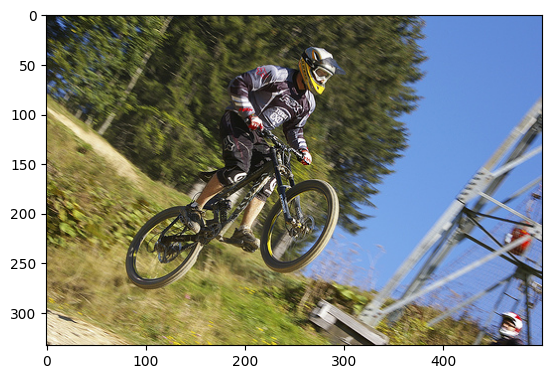

In [31]:
path = 'VOCdevkit/VOC2012/JPEGImages/2012_004308.jpg'
img = img_path_to_bovw(path, kmeans)
plt.imshow(load_rbg(path))


In [32]:
_, indices = neighbors.kneighbors([img], n_neighbors=10)
indices


array([[ 50, 162, 558,  70, 334, 474,  80, 383, 190, 687]], dtype=int64)

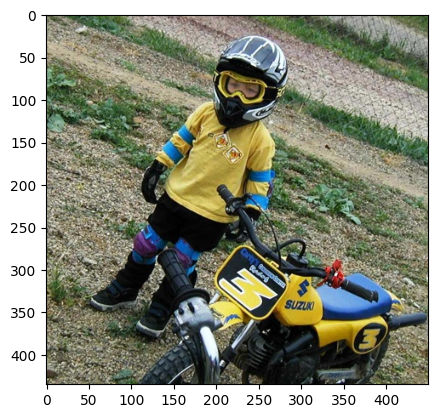

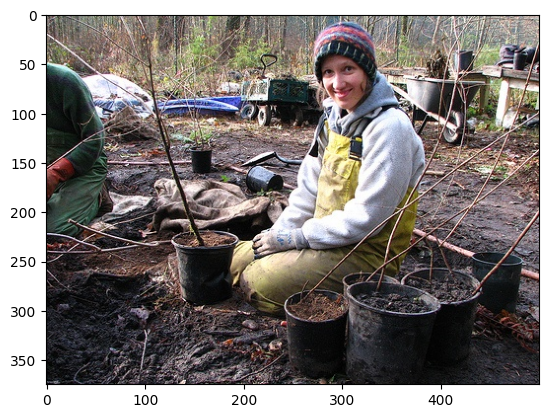

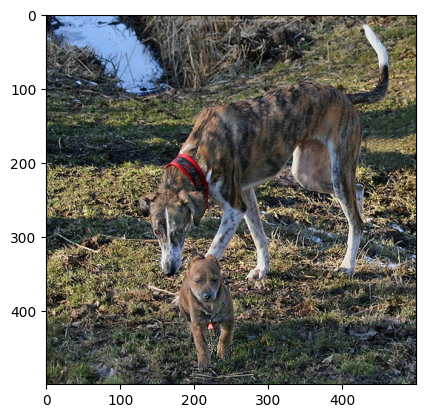

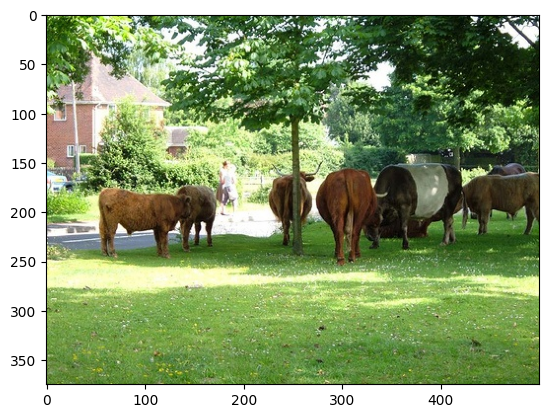

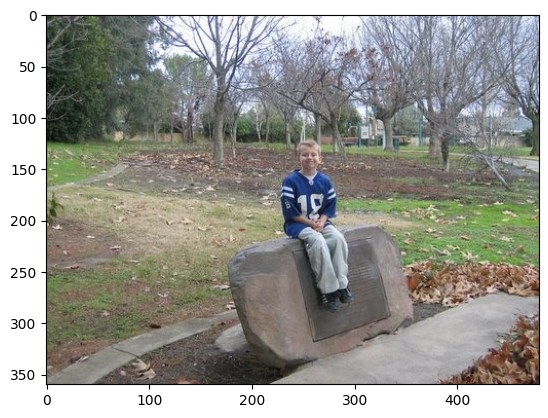

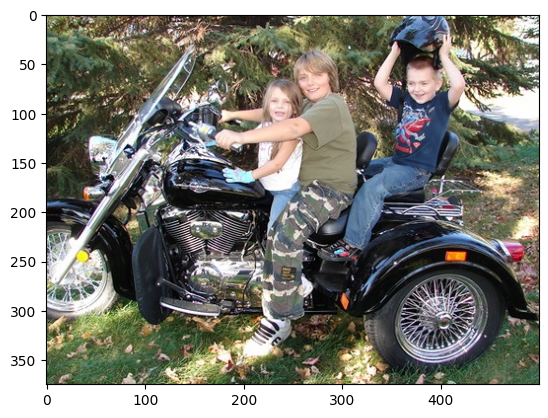

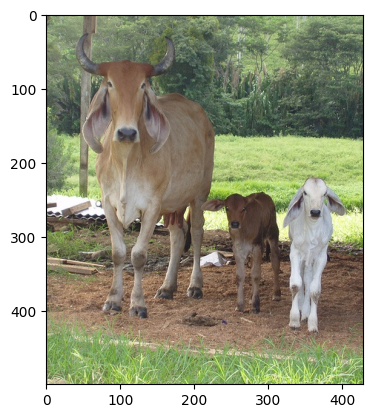

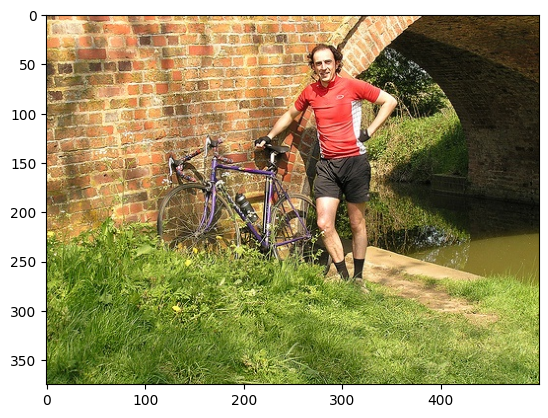

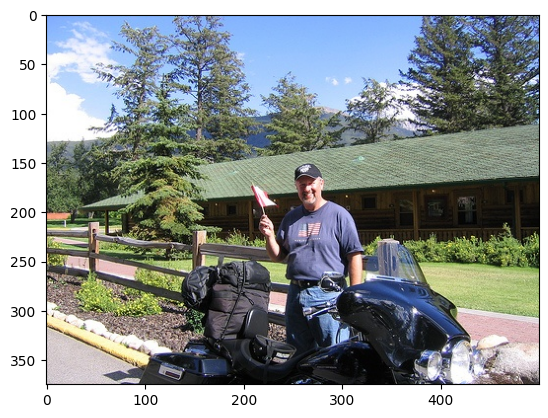

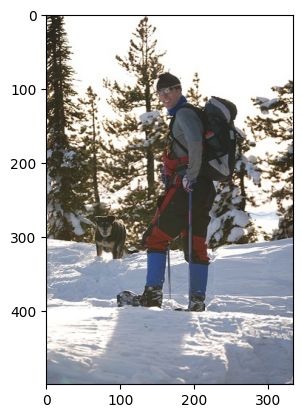

In [33]:
for idx in indices.flat:
    plt.imshow(load_rbg(df2.loc[idx]['path']))
    plt.show()
